# Manual Backpropagation

In [1]:
# as discussed in the previous notebook,
# let's figure out the intermediate grads with our dummy expression (dL/df, dL/de, ..., dL/da)
# but for that, let us first update our Value class to hold and compute the grads

In [2]:
# updated micrograd Value class to compute and hold grads

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label  # optional, Value variable/node name
        self.grad = 0.0     # initially, the grad be zero (means no effect on output)

        # internal variables used for autograd graph construction
        self._prev = set(_children) # previous node
        self._op = _op              # the operation that produced this node

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out


In [3]:
# updated visualization functions to show grads

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
# Importing expression from the previous notebook
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a * b;  c.label='c'
d = Value(10.0, label='d')
e = c + d;  e.label='e'
f = Value(-2.0, label='f')
L = e * f;  L.label='L'
print(L) # L is loss function which we will try to minimize in backpropagation

Value(data=-8.0)


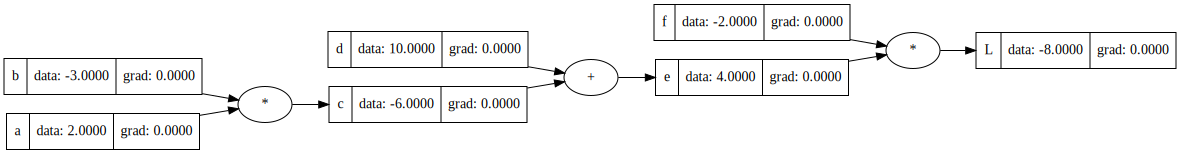

In [5]:
draw_dot(L)

In [6]:
# initially all the grads are zero (we assume the nodes have no effect on the output L, on initialization)
# let us now calculate and fill in the grads, by performing backpropagation manually

# Calculating the grads Manually

In [7]:
# dL/dL should be 1
# if L changes by h, then rate of change is also h
# so, slope = (L + h) / (L + h) = 1
# also by first principles, f(x) = L, f(x + h) = L + h, slope = [(L + h) - (L)] / h = 1
# idk why i am doing this, LoL, it's trivial :D

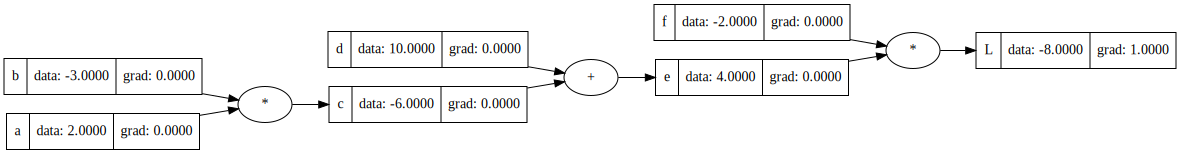

In [8]:
# let's manually update the same
L.grad = 1.0
draw_dot(L)

In [9]:
# now dL/de and dL/df

# L = e * f
# using derivative rules and formulas from calculus,
# dL/de = f
# and
# dL/df = e

# we can derive the same from first principles. let's do for dL/de
# grad = [f(x+h) - f(x)] / h, when lim h->0
# here, f(x) = L(e) = e*f. so, f'(x) = dL/de
# => [(e+h)*f - e*f] / h
# => (ef + hf - ef) / h
# => hf / h
# => f
# so, dL/de = f

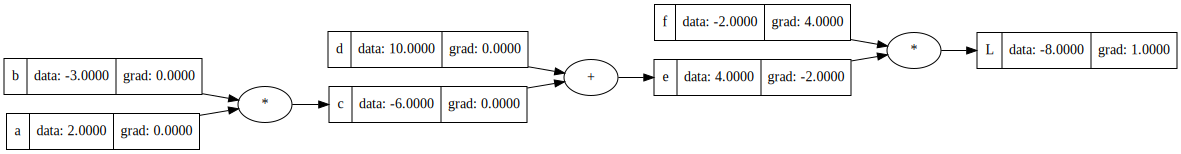

In [10]:
# let's manually update the same
e.grad = -2.0
f.grad = 4.0
draw_dot(L)

In [11]:
# now for the most important node!
# we need to derive dL/dd
# 
# using chain rule and formulas from calculus:
# dL/dd = dL/de * de/dd
#
# now, we already know dL/de = e.grad = -2.0
# we just need to find out de/dd = ?

In [12]:
# now, e = d + c
# => de/dd = dd/dd + dc/dd
# => de/dd = 1 + dc/dd
# now, c and d are independent, hence dc/dd = 0
# so, de/dd = 1.0

# we can also derive the same from the first principles:
# grad = [f(x+h) - f(x)] / h, when lim h->0
# here, f(x) = e = d + c. so, f'(x) = de/dd
# => [(d+h + c) - (d + c)] / h
# => (d + h + c - d - c) / h
# => h/h
# => 1.0

# so, 
# de/dd = 1.0
# and by symmetry,
# de/dc = 1.0

In [13]:
# using chain rule:
# dL/dd = dL/de * de/dd, and
# dL/dc = dL/de * de/dc

# substituting values from above:
# dL/dd = dL/de * 1.0, and
# dL/dc = dL/de * 1.0
#
# we get:
# dL/dd = -2.0
# dL/dc = -2.0

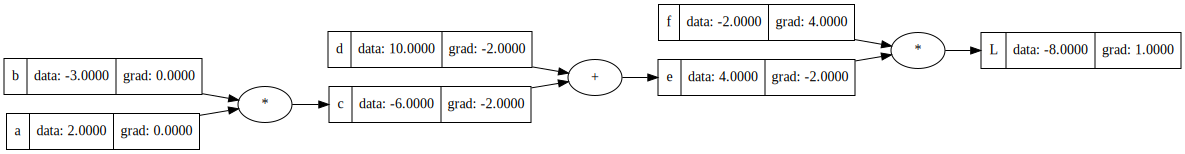

In [14]:
# let's manually update the same
c.grad = -2.0
d.grad = -2.0
draw_dot(L)

In [15]:
# now the final nodes
# dL/da and dL/db

# now, this would be similar to what we did before, and i am gonna skip the derivations.
# applying chain rule:
# dL/da = dL/dc * dc/da

# let's find out dc/da quickly:
# c = a * b
# => dc/da = b

# so,
# dL/da = dL/dc * dc/da = dL/dc * b = -2.0 * -3.0 = 6.0

# similarly,
# dL/db = dL/dc * dc/db = dL/dc * a = -2.0 * 2.0 = -4.0

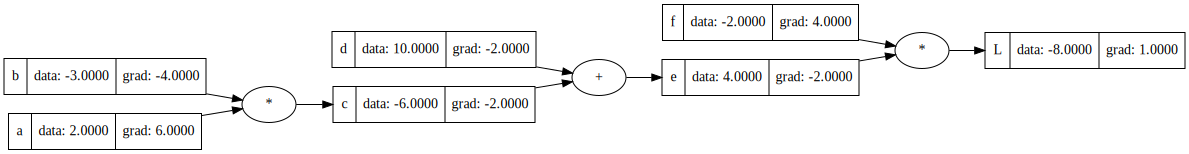

In [16]:
# let's manually update the same
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

In [17]:
# AND... WE DID IT !!!

In [18]:
# Let's verify by writing a function that derives these values from first principles:
def compute_grad_of_L(wrt='', h=0.001):
    # initial expression
    a = Value(2.0)
    b = Value(-3.0)
    c = a * b
    d = Value(10.0)
    e = c + d
    f = Value(-2.0)
    L = e * f
    L1 = L.data

    # with slight nudge of h
    a = Value(2.0 + h) if wrt == 'a' else Value(2.0)
    b = Value(-3.0 + h) if wrt == 'b' else Value(-3.0)
    c = Value((a * b).data + h) if wrt == 'c' else a * b
    d = Value(10.0 + h) if wrt == 'd' else Value(10.0)
    e = Value((c + d).data + h) if wrt == 'e' else c + d
    f = Value(-2.0 + h) if wrt == 'f' else Value(-2.0)
    L = Value((e * f).data + h) if wrt == 'L' else e * f
    L2 = L.data

    return (L2 - L1) / h

In [19]:
# inline gradient check, numerically by tweaking the variables by 'h' amount
# and seeing how L get's affected. (this is like deriving grad from first principles numerically)
print("computing grad numerically using compute_grad_of_L(wrt, h):")
for wrt in ['L', 'f', 'e', 'd', 'c', 'b', 'a']:
    grad = compute_grad_of_L(wrt=wrt)
    print(f"dL/d{wrt} = {grad}")

computing grad numerically using compute_grad_of_L(wrt, h):
dL/dL = 1.000000000000334
dL/df = 3.9999999999995595
dL/de = -2.000000000000668
dL/dd = -1.9999999999988916
dL/dc = -2.000000000000668
dL/db = -3.9999999999995595
dL/da = 6.000000000000227


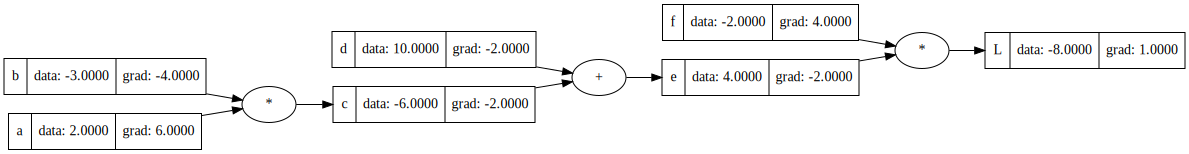

In [20]:
# let's see what we got from manual derivations and dry running backpropagation manually:
draw_dot(L)

In [21]:
# Yep! it matches! we did it!! (ignoring the floating point garbage and oddness!)

In [22]:
# so, moral of the story,
# if there is a (*) node, local grad is swapping the data
# if there is a (+) node, local grad is 1.0

# and the actual grad, take the local grad, and multiply with it's parent node's grad.
# for (*) node, actual grad is swapping the data of child nodes, and multiply it with parent node's grad
# for (+) node, actual grad is parent grad! it distributes the grad backward to it's leaf nodes

# here is an illustration below to remember the local grad for (*) and (+) nodes:

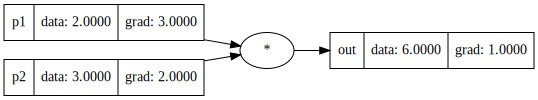

In [23]:
p1 = Value(2.0, label='p1')
p2 = Value(3.0, label='p2')
prod_out = p1 * p2;  prod_out.label='out'
prod_out.grad = 1.0
p1.grad = 3.0   # value of p2 node
p2.grad = 2.0   # value of p1 node
draw_dot(prod_out)

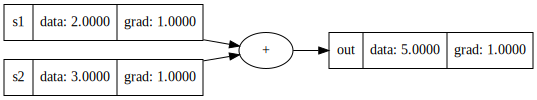

In [24]:
s1 = Value(2.0, label='s1')
s2 = Value(3.0, label='s2')
sum_out = s1 + s2;  sum_out.label='out'
sum_out.grad = 1.0
s1.grad = 1.0   # value of connected node * local grad = 1.0
s2.grad = 1.0   # value of connected node * local grad = 1.0
draw_dot(sum_out)

In [25]:
# recap:
# we iterated through all the nodes one by one, applied the chain rule
# in each operation, we know the local derivatives are, and we multiply them onto the derivative
# so we go through recursively and multiply on the local derivatives, and that's what backpropagation is!
# it's just a recursive application of chain rule backwards through the computation graph!

# Preview a single Optimization step

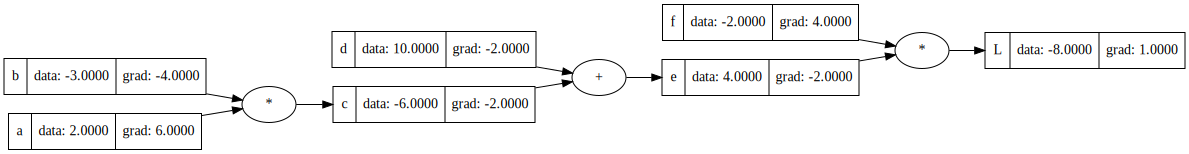

In [26]:
# now that we have the grad, we can use them to nudge the inputs, leaf nodes or any nodes to influence the output
# and due to the grads, we know which direction to go and how it will influence the outputs

# let's see an example, where we nudge the leaf nodes (a, b, d, f) to influence the output L
# let's print our expression graph again:
draw_dot(L)

In [27]:
# if we nudge in direction of the gradients, we will expect a positive influence on output

# so, if we increase the values of leaf nodes in direction of grad, we will see L go up
# let's see this in action:

In [28]:
# re defining the expression again with the grads
a = Value(2.0, label='a');  a.grad = 6.0
b = Value(-3.0, label='b'); b.grad = -4.0
c = a * b;  c.label='c';    c.grad = -2.0
d = Value(10.0, label='d'); d.grad = -2.0
e = c + d;  e.label='e';    e.grad = -2.0
f = Value(-2.0, label='f'); f.grad = 4.0
L = e * f;  L.label='L';    L.grad = 1.0

print(L) # L is loss function which we will try to minimize in backpropagation

Value(data=-8.0)


In [29]:
# factor by which the values would be nudged
alpha = 0.01    # we will see this in future, where it is the learning rate

# let's nudge the values
a.data += alpha * a.grad
b.data += alpha * b.grad
d.data += alpha * d.grad
f.data += alpha * f.grad

# let's also re run the forward pass
c = a * b
e = c + d
L = e * f

print(L)

Value(data=-7.286496)


In [30]:
# so we see, the output value got increased successfully!